In [2]:
import time
import neptune # type: ignore
import datetime
import torch
import torch.optim as optim
import torch.nn as nn

from torch.optim import SGD, Adam # type: ignore
from torch.optim.lr_scheduler import LambdaLR # type: ignore
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchmetrics import Accuracy # type: ignore

from configs.utils import *
from datasets.utils import *
from datasets.utils import FlairDs
from easydict import EasyDict # type: ignore
from argparse import ArgumentParser, Namespace
from model.segmenter import Segmenter
from model.segmenter_adapt import SegmenterAdapt
from dl_toolbox.callbacks import EarlyStopping # type: ignore
from model.segmenter_adapt import *
from configs.utils import *
from datasets.utils import *
from easydict import EasyDict

/d/maboum/dil_seg/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
args = Namespace(
    initial_lr=0.01,
    final_lr=0.005,
    lr_milestones=(20, 80),
    epoch_len=100,
    sup_batch_size=4,
    crop_size=256,
    workers=6,
    img_aug='d4_rot90_rot270_rot180_d1flip',
    max_epochs=200,
    sequence_path="",
    train_split_coef=0.85,
    strategy='continual_{}',
    commit=None,
    train_type="adaptmlp",
    replay=False,  # Par défaut, `store_true` est `False`
    config_file= "/d/maboum/css-peft/configs/config.yml",
    ffn_adapt=True,  # Par défaut, `store_true` est `True`
    ffn_num=64,
    vpt=False,  # Par défaut, `store_true` est `False`
    vpt_num=1,
    fulltune=False  # Par défaut, `store_true` est `False`
)

tuning_config = EasyDict(
        # AdaptFormer
        ffn_adapt=args.ffn_adapt,
        ffn_option="parallel",
        ffn_adapter_layernorm_option="none",
        ffn_adapter_init_option="lora",
        ffn_adapter_scalar="0.1",
        ffn_num=args.ffn_num,
        d_model=768,
        # VPT related
        vpt_on=args.vpt,
        vpt_num=args.vpt_num,
        nb_task = 3, 
        decoder = "linear"
    )
config_file = "/d/maboum/css-peft/configs/config.yml"
config = load_config_yaml(file_path = config_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = config["dataset"]
data_config = dataset["flair1"]
seed = config["seed"]
directory_path = data_config["data_path"]
metadata = data_config["metadata"]
data_sequence = data_config["task_name"]
epochs = data_config['epochs']
eval_freq = data_config['eval_freq']
im_size = data_config["im_size"]
lr = data_config['learning_rate']
win_size = data_config["window_size"]
win_stride = data_config["window_stride"]
n_channels = data_config['n_channels']
n_class = 13
class_names = data_config["classnames_binary"]
eval_freq = data_config["eval_freq"]

selected_model = '_'.join([config["model_name"], "224"])
model = config["model"]
model_config = model[selected_model]
im_size = model_config["image_size"]
patch_size = model_config["patch_size"]
d_model = model_config["d_model"]
n_heads = model_config["n_heads"]
n_layers = model_config["n_layers"]
d_encoder = model_config["d_model"]

train_type = args.train_type
lora_params = config["lora_parameters"]
lora_rank = lora_params["rank"]
lora_alpha = lora_params["rank"]

binary = data_config["binary"]

In [4]:
seed = config["seed"]
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.autograd.set_detect_anomaly(True) 
random.seed(seed)

In [5]:
run = neptune.init_run(
        project="continual-semantic-segmentation/peft-methods",
        api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwN2IzOGYxMC0xYTg5LTQxMGEtYjE3Yy1iNDVkZDM1MmEzYzIifQ==",
        name="AdaptFormerSeg",
        description="First run for Adapters project",
        tags=["adaptmlp", "test", "segmenter", "vit-large"],
        mode= "debug")

In [6]:
# Learning rate
def lambda_lr(epoch):
    m = epoch / args.max_epochs
    if m < args.lr_milestones[0]:
        return 1
    elif m < args.lr_milestones[1]:
        return 1 + ((m - args.lr_milestones[0]) / (
                    args.lr_milestones[1] - args.lr_milestones[0])) * (
                            args.final_lr / args.initial_lr - 1)
    else:
        return args.final_lr / args.initial_lr

In [7]:
# Callbacks
segmentation_model = SegmenterAdapt(im_size, n_layers, d_model, d_encoder, 4 * d_model, n_heads, n_class,
                                                patch_size, selected_model, tuning_config=tuning_config,
                                                model_name=config["model_name"], id = 0).to(device)

segmentation_model.load_pretrained_weights()
segmentation_model_path = os.path.join("C:/Users/marie/css-peft/checkpoints",args.sequence_path.format(seed),
                                 '{}_{}'.format(args.strategy.format(train_type),seed))

optimizer = SGD(segmentation_model.parameters(),
                lr=args.initial_lr,
                momentum=0.9)
scheduler = LambdaLR(optimizer,lr_lambda= lambda_lr, verbose = True)
loss_fn = torch.nn.CrossEntropyLoss().cuda()
accuracy = Accuracy(task='multiclass',num_classes=n_class).cuda()

Pretrained model loaded successfully from timm!


/d/maboum/dil_seg/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [8]:
segmentation_model 

SegmenterAdapt(
  (encoder): VisionTransformerAdapt(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (adaptmlp_pool):

In [16]:
segmentation_model(torch.randn(8, 3,224, 224).to(device), id= 1).shape

torch.Size([8, 13, 224, 224])

In [24]:
import torch

# Supposons que 'segmentation_model' est déjà défini et initialisé
outputs = {}  # Dictionnaire pour stocker les activations

# Définir une fonction hook
def get_activation(name):
    def hook(model, input, output):
        outputs[name] = output
    return hook

for name in dict(segmentation_model.named_modules()):
    layer = dict(segmentation_model.named_modules())[name]
    layer.register_forward_hook(get_activation(name))

# Faire passer des données dans le modèle
input_data = torch.randn(8, 3, im_size, im_size).to(device)  # Par exemple
output = segmentation_model(input_data, id=0)  # Passe avant



Activation of encoder.patch_embed.proj: torch.Size([8, 768, 28, 28])
Activation of encoder.patch_embed: torch.Size([8, 784, 768])
Activation of encoder.dropout: torch.Size([8, 785, 768])
Activation of encoder.blocks.0.norm1: torch.Size([8, 785, 768])
Activation of encoder.blocks.0.attn.qkv: torch.Size([8, 785, 2304])
Activation of encoder.blocks.0.attn.attn_drop: torch.Size([8, 12, 785, 785])
Activation of encoder.blocks.0.attn.proj: torch.Size([8, 785, 768])
Activation of encoder.blocks.0.attn.proj_drop: torch.Size([8, 785, 768])
Activation of encoder.blocks.0.attn: [torch.Size([8, 785, 768]), torch.Size([8, 12, 785, 785])]
Activation of encoder.blocks.0.drop_path: torch.Size([8, 785, 768])
Activation of encoder.blocks.0.adaptmlp_pool.0.down_proj: torch.Size([8, 785, 64])
Activation of encoder.blocks.0.adaptmlp_pool.0.non_linear_func: torch.Size([8, 785, 64])
Activation of encoder.blocks.0.adaptmlp_pool.0.up_proj: torch.Size([8, 785, 768])
Activation of encoder.blocks.0.adaptmlp_pool.

In [26]:
outputs['encoder.blocks.11.adaptmlp_pool.0.up_proj'].shape

torch.Size([8, 785, 768])

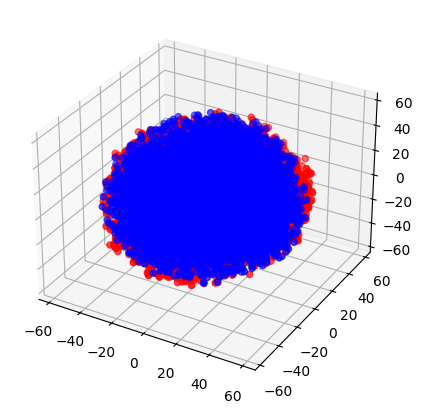

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
%matplotlib inline
# Supposons que 'features' est votre tensor de shape [8, 785, 768]
features = outputs['encoder.blocks.1.adaptmlp_pool.0.up_proj'].cpu()

# Redimensionner le tensor à 2D
features_2d = features.view(-1, features.shape[-1])

# Convertir le tensor en numpy array
features_np = features_2d.detach().numpy()

# Supposons que 'features2' est votre deuxième tensor de shape [8, 785, 768]
features2 = outputs['encoder.blocks.11.adaptmlp_pool.0.up_proj'].cpu()

# Redimensionner le tensor à 2D
features2_2d = features2.view(-1, features2.shape[-1])

# Convertir le tensor en numpy array
features2_np = features2_2d.detach().numpy()

# Apply t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=0)
features_2d_tsne = tsne.fit_transform(features_np)
features2_2d_tsne = tsne.fit_transform(features2_np)

# Visualize with matplotlib
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1], features_2d_tsne[:, 2], c='blue')  # First set of features
ax.scatter(features2_2d_tsne[:, 0], features2_2d_tsne[:, 1], features2_2d_tsne[:, 2], c='red')  # Second set of features
plt.show()

In [ ]:
train_imgs, test_imgs = [],[]
for step,domain in enumerate(data_sequence[:2]):

    img = glob.glob(os.path.join(directory_path, '{}/Z*_*/img/IMG_*.tif'.format(domain)))
    random.shuffle(img)
    train_imgs += img[:int(len(img)*args.train_split_coef)]
    test_imgs += img[int(len(img)*args.train_split_coef):]
    random.shuffle(train_imgs)
    # Train&Validation Data
    domain_img_train = train_imgs[:int(len(train_imgs)*args.train_split_coef)]
    domain_img_val = train_imgs[int(len(train_imgs)*args.train_split_coef):]
    train_loader = create_train_dataloader(domain_img_train, args, data_config, binary= binary)
    val_loader = create_val_dataloader(domain_img_val, args, data_config, binary= binary)

    for param in segmentation_model.encoder.parameters():
        param.requires_grad = False
    # Unfreeze the adapt_mlp layers
    for name, param in segmentation_model.encoder.named_parameters():
        if 'adaptmlp' in name:
            param.requires_grad = True

    for epoch in range(1,args.max_epochs):
        time_ep = time.time()
        segmentation_model, train_acc, train_loss = train_function(segmentation_model,train_loader, 
                                            device,optimizer, loss_fn,
                                            accuracy, epoch, data_config, run)
        print(train_acc, train_loss)
        scheduler.step()
        segmentation_model, val_loss, val_acc = validation_function(segmentation_model,val_loader, 
                                                        device,loss_fn,
                                                        accuracy, epoch, data_config, run)
        print(val_acc, val_loss)
        early_stopping(val_loss,segmentation_model)
        if early_stopping.early_stop:
            break
        time_ep = time.time() - time_ep
    segmentation_model.increment()
